# 과제: 자전거 대여 수요 예측 경진대회 모델 성능 개선

- [자전거 대여 수요 예측 경진대회 링크](https://www.kaggle.com/c/bike-sharing-demand)

- [모델링 코드 참고 링크](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)

수강생분의 이름과 학번을 입력해주세요.

In [155]:
print("이혜림", "20211924")

이혜림 20211924


In [156]:
import pandas as pd
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 피처 엔지니어링

### 이상치 제거

In [157]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

In [158]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생 변수(피처) 추가

In [159]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

### 필요 없는 피처 제거

In [160]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

### 데이터 나누기

In [161]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

## 평가지표 계산 함수 작성

In [162]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

# 5. 성능 개선 I : 릿지 회귀 모델

## 5.1 하이퍼 파라미터 최적화(모델 훈련)

### 모델 생성

In [163]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

### 그리드서치 객체 생성

In [164]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

### 그리드서치 수행

In [165]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [166]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


## 5.2 성능 검증

In [167]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

릿지 회귀 RMSLE 값 : 1.0205


# 6. 성능 개선 II : 라쏘 회귀 모델

## 6.1 하이퍼 파라미터 최적화(모델 훈련)

In [168]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


## 6.2 성능 검증

In [169]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


# 7. 성능 개선 III : 랜덤 포레스트 회귀 모델

## 7.1 하이퍼 파라미터 최적화(모델 훈련)

In [170]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


## 7.2 모델 성능 검증

In [171]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


## 7.3 예측 및 결과 제출

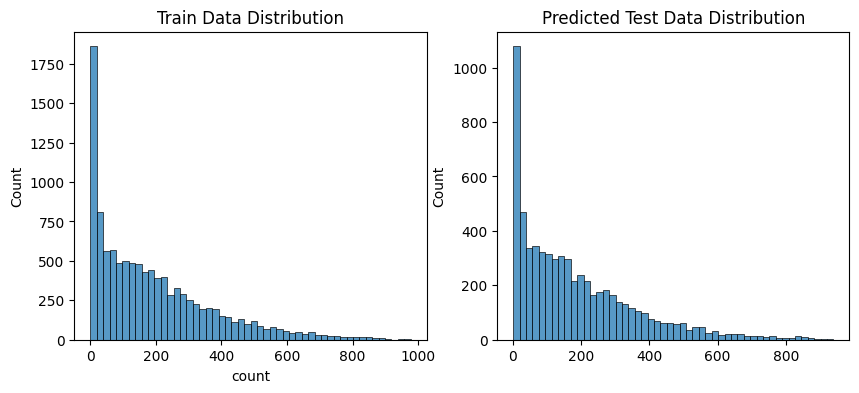

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [173]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)

# 실습 과제: 개선시도 3가지, 0.39567 보다 낮은 score 달성
아래의 3가지를 모두 개선 시도하여 0.39567 보다 낮은 score를 달성하시오. 과제로 제공한 코드를 기반으로 다른 캐글 코드의 일부 내용을 참고하여 수정하는 것은 허용합니다.

* 1) 피처 엔지니어링
* 2) 모델 선택
* 3) 하이퍼파라미터 최적화

성능 개선 시도한 내용 간략히 작성해주세요.
* 1) 피처 엔지니어링: 수행한 내용 작성
* 2) 모델 선택: 수행한 내용 작성
* 3) 하이퍼파라미터 최적화: 수행한 내용 작성

0.39567 보다 낮은 score 달성한 성능 증빙자료는 과제함에 제출해주세요.

In [174]:
# 1) 피처 엔지니어링 하기

import pandas as pd
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [175]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [176]:
test.head()
# 수정할 부분 1. test에는 casual, registered 컬럼이 존재하지 않음.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [177]:
# 수정할 부분 2. 이전 시각화 부분에서 weather가 4일 때(폭우, 폭설, 천둥)는 이상치였음.
train.weather.value_counts()
train = train[train['weather'] != 4]

In [178]:
# 수정할 부분 3. 파생 피처를 만들고 나면, season 피처는 필요 없음 (대신 month 피처를 사용할 것)
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [179]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0]).astype(int)
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1]).astype(int)
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0]).astype(int)
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday()).astype(int)

all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,1,4,5


In [180]:
all_data.info()
# casual, registered는 test 데이터에 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17378 non-null  object 
 1   season      17378 non-null  int64  
 2   holiday     17378 non-null  int64  
 3   workingday  17378 non-null  int64  
 4   weather     17378 non-null  int64  
 5   temp        17378 non-null  float64
 6   atemp       17378 non-null  float64
 7   humidity    17378 non-null  int64  
 8   windspeed   17378 non-null  float64
 9   casual      10885 non-null  float64
 10  registered  10885 non-null  float64
 11  count       10885 non-null  float64
 12  date        17378 non-null  object 
 13  year        17378 non-null  int64  
 14  month       17378 non-null  int64  
 15  hour        17378 non-null  int64  
 16  weekday     17378 non-null  int64  
dtypes: float64(6), int64(9), object(2)
memory usage: 2.3+ MB


In [181]:
# test 데이터에 없던 내용 + datetime, date, month, temp 삭제
# temp 대신 atemp만 사용할 것 = 이유 : 온도와 체감온도는 비례하기 때문에, 체감온도만 사용하기로 함

drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month', 'temp']

all_data = all_data.drop(drop_features, axis=1)
all_data.head()

,season,holiday,workingday,weather,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,14.395,81,16.0,2011,0,5
1,1,0,0,1,13.635,80,40.0,2011,1,5
2,1,0,0,1,13.635,80,32.0,2011,2,5
3,1,0,0,1,14.395,75,13.0,2011,3,5
4,1,0,0,1,14.395,75,1.0,2011,4,5


In [182]:
all_data.info()
# 이제 count 제외하고 모든 데이터가 다 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17378 non-null  int64  
 1   holiday     17378 non-null  int64  
 2   workingday  17378 non-null  int64  
 3   weather     17378 non-null  int64  
 4   atemp       17378 non-null  float64
 5   humidity    17378 non-null  int64  
 6   count       10885 non-null  float64
 7   year        17378 non-null  int64  
 8   hour        17378 non-null  int64  
 9   weekday     17378 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


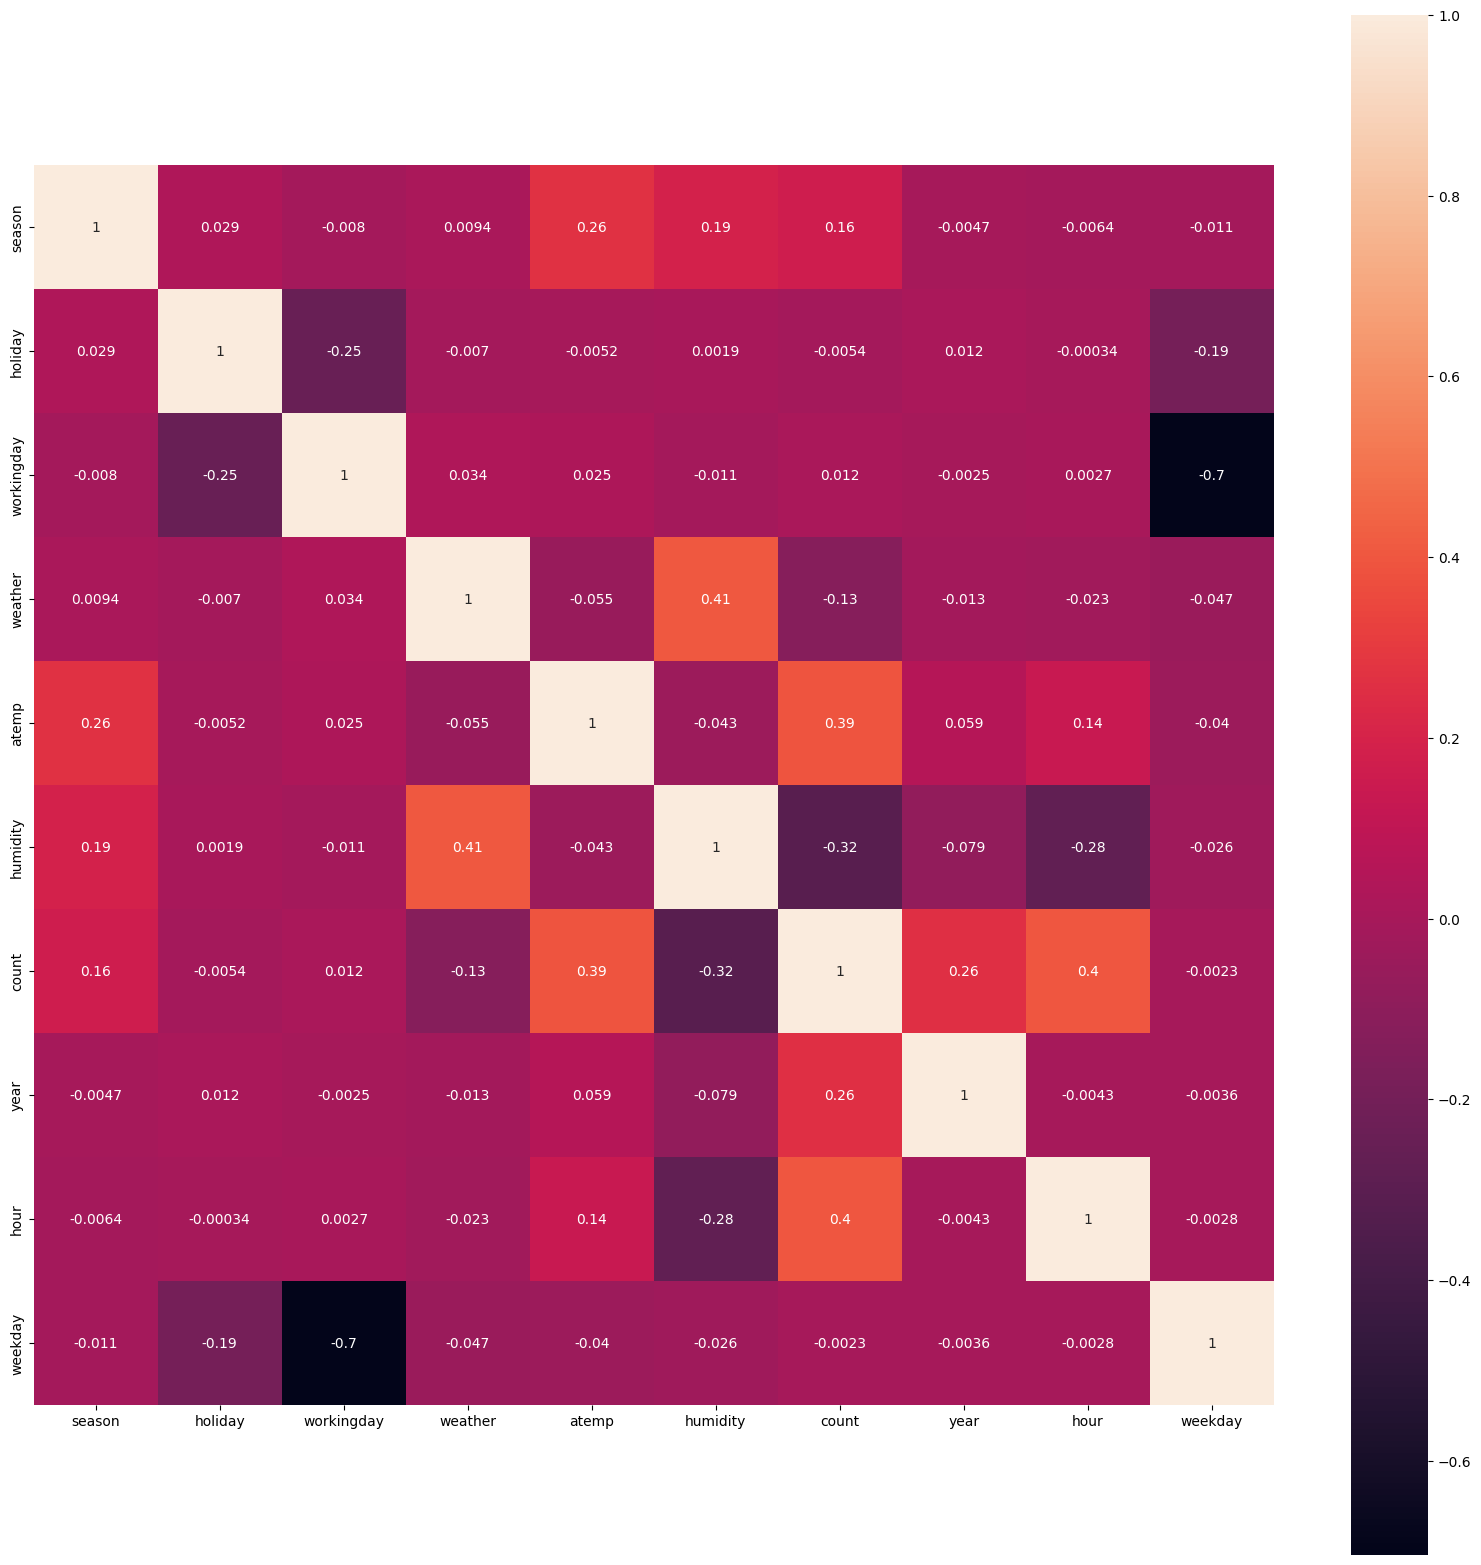

In [183]:
# 컬럼 간 상관계수 보기
import seaborn as sns
import matplotlib.pyplot as plt

X_train = all_data[~pd.isnull(all_data['count'])]

fig = plt.figure(figsize=[20,20])
ax = sns.heatmap(X_train.corr(), annot=True, square=True)

In [184]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

y = X_train['count'].astype(int) # 타깃값

# 타깃값 count 제거
# X_train = X_train.drop(['count'], axis=1)
# X_test = X_test.drop(['count'], axis=1)

X_train.head(20)

,season,holiday,workingday,weather,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,14.395,81,16.0,2011,0,5
1,1,0,0,1,13.635,80,40.0,2011,1,5
2,1,0,0,1,13.635,80,32.0,2011,2,5
3,1,0,0,1,14.395,75,13.0,2011,3,5
4,1,0,0,1,14.395,75,1.0,2011,4,5
5,1,0,0,2,12.880,75,1.0,2011,5,5
6,1,0,0,1,13.635,80,2.0,2011,6,5
7,1,0,0,1,12.880,86,3.0,2011,7,5
8,1,0,0,1,14.395,75,8.0,2011,8,5
9,1,0,0,1,17.425,76,14.0,2011,9,5


In [185]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10885 entries, 0 to 10884
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10885 non-null  int64  
 1   holiday     10885 non-null  int64  
 2   workingday  10885 non-null  int64  
 3   weather     10885 non-null  int64  
 4   atemp       10885 non-null  float64
 5   humidity    10885 non-null  int64  
 6   count       10885 non-null  float64
 7   year        10885 non-null  int64  
 8   hour        10885 non-null  int64  
 9   weekday     10885 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 935.4 KB


In [186]:
# 평가지표 함수

import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [187]:
# 모델에 넣기 직전에 count 컬럼 지우기

y = X_train['count'].astype(int)

X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

<Axes: xlabel='count', ylabel='Count'>

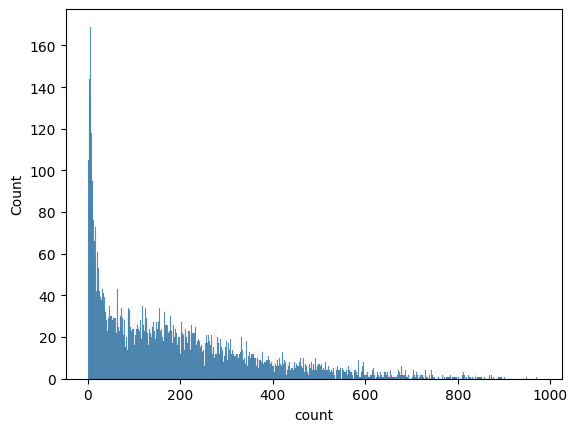

In [188]:
sns.histplot(y, bins=range(y.min().astype('int'), y.max().astype('int')))

# 2) 모델 선택하기 [XGBoost]

실습에서는 배깅 버전인 RandomForest를 사용했었음
이번에는 부스팅 버전인 XGBoost 사용

In [189]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10885 entries, 0 to 10884
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10885 non-null  int64  
 1   holiday     10885 non-null  int64  
 2   workingday  10885 non-null  int64  
 3   weather     10885 non-null  int64  
 4   atemp       10885 non-null  float64
 5   humidity    10885 non-null  int64  
 6   year        10885 non-null  int64  
 7   hour        10885 non-null  int64  
 8   weekday     10885 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 850.4 KB


In [190]:
print("X train 개수 확인 : ", X_train.shape)
print("y 개수 확인 : ", y.shape)

X train 개수 확인 :  (10885, 9)
y 개수 확인 :  (10885,)


In [192]:
# 1. 최적화 방법으로 랜덤서치 사용

from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
log_y = np.log(y)

xgb_model = XGBRegressor(random_state=1924, n_jobs = -1)

xgb_params = {
    'n_estimators' : list(range(200, 310, 10)),
    'max_depth' : list(range(3, 11, 1)),
    'min_child_weight' : [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0],
    'random_state' : [1924],
    'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2],
    'n_jobs' : [-1],
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8, 0.9, 1]}
                       

cv_model = RandomizedSearchCV(xgb_model, xgb_params, 
                              n_iter = 100, cv = 5, scoring = rmsle_scorer
                            )

# cv_model.fit(X_train, y_train)
cv_model.fit(X_train, log_y)

print("최적의 파라미터 : ", cv_model.best_params_)
print("최적의 점수 : ", cv_model.best_score_)
good_model = cv_model.best_estimator_

최적의 파라미터 :  {'subsample': 0.6, 'random_state': 1924, 'n_jobs': -1, 'n_estimators': 220, 'min_child_weight': 1.0, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
최적의 점수 :  -0.3708501973848092


Text(0.5, 1.0, 'Predicted Test Data Distribution')

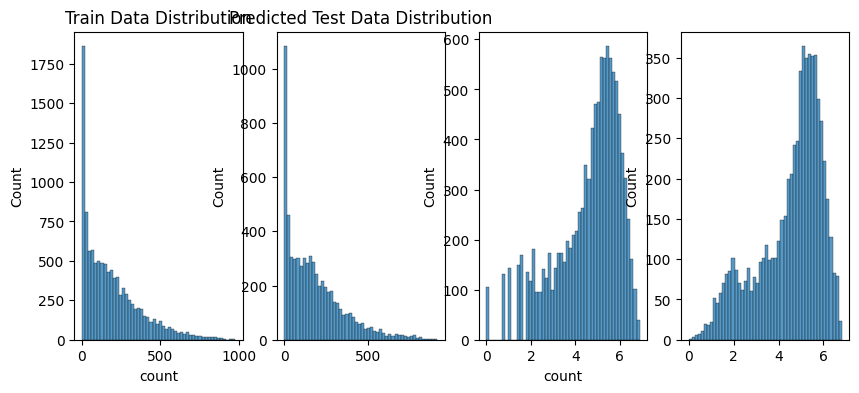

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

test_pred = good_model.predict(X_test)

figure, axes = plt.subplots(ncols=4)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(test_pred), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution')
sns.histplot(np.log(y), bins=50, ax=axes[2])
axes[0].set_title('Train Data Distribution')
sns.histplot(test_pred, bins=50, ax=axes[3])
axes[1].set_title('Predicted Test Data Distribution')

제출 결과 최저 점수가 0.42로 그다지 좋지 않았음.

In [194]:
# 2. 최적화 방법으로 베이지안 최적화 사용

from sklearn import metrics
import xgboost as xgb

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
log_y = np.log(y)

# 탐색 대상 함수 만들기 (using XGBRegressor)
def XGBModel(max_depth, learning_rate, n_estimators, gamma,
            min_child_weight, subsample, colsample_bytree, n_jobs = -1) :
    
    xgb_model = xgb.XGBRegressor(max_depth = int(max_depth),
                                learning_rate = learning_rate,
                                n_estimators = int(n_estimators),
                                gamma = gamma,
                                min_child_weight = min_child_weight,
                                subsample = subsample,
                                colsample_bytree = colsample_bytree,
                                n_jobs = n_jobs)
    xgb_model.fit(X_train, log_y)
    
    xgb_model_pred = xgb_model.predict(X_train)
    
    rmsle_xgb = rmsle(log_y, xgb_model_pred, True)
    
    return rmsle_xgb

In [196]:
# 베이지안 최적화 실행
from bayes_opt import BayesianOptimization
import numpy as np

test_list = {'max_depth' : (3, 12),
                'learning_rate' : (0.01, 0.2),
                'n_estimators' : (200, 600),
                'gamma' : (0, 100),
                'min_child_weight' : (0, 5),
                'subsample' : (0.5, 1),
                'colsample_bytree' : (0.2, 1)
            }

bayesian = BayesianOptimization(f = XGBModel, pbounds = test_list, verbose = 2, random_state = 1924)

bayesian.maximize(init_points = 2, n_iter = 50)

print(bayesian.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.3036    | 0.4359    | 4.356     | 0.07422   | 9.202     | 2.797     | 344.4     | 0.9291    |
| 2         | 0.43      | 0.4461    | 60.24     | 0.08665   | 7.173     | 2.2       | 225.8     | 0.7293    |
| 3         | 0.4612    | 0.871     | 58.8      | 0.02549   | 8.684     | 2.371     | 226.1     | 0.6693    |
| 4         | 0.4265    | 0.4281    | 53.37     | 0.1658    | 11.74     | 1.884     | 229.7     | 0.6876    |
| 5         | 0.4078    | 0.6855    | 54.05     | 0.1487    | 9.753     | 1.897     | 222.2     | 0.9225    |
| 6         | 0.6944    | 1.0       | 60.17     | 0.01      | 12.0      | 5.0       | 229.2     | 0.5       |
| 7         | 0.4392    | 0.7188    | 59.64     | 0.1237    | 10.8      | 3.056     | 232.0     | 0.712     |
| 8       

In [197]:
beyes_best = xgb.XGBRegressor(max_depth = 3,
                                learning_rate = 0.017785323492127116,
                                n_estimators = 457,
                                gamma = 89.24577974509167,
                                min_child_weight = 2.661875942260592,
                                subsample = 0.9502693220091694,
                                colsample_bytree = 0.20639209192519462,
                                n_jobs = -1)
beyes_best.fit(X_train, log_y)

beyes_best_pred = beyes_best.predict(X_train)

print("베이지안 최적화 RMSLE 결과 : ", rmsle(log_y, beyes_best_pred, True))

베이지안 최적화 RMSLE 결과 :  0.8449921037426668


Text(0.5, 1.0, 'Predicted Test Data Distribution')

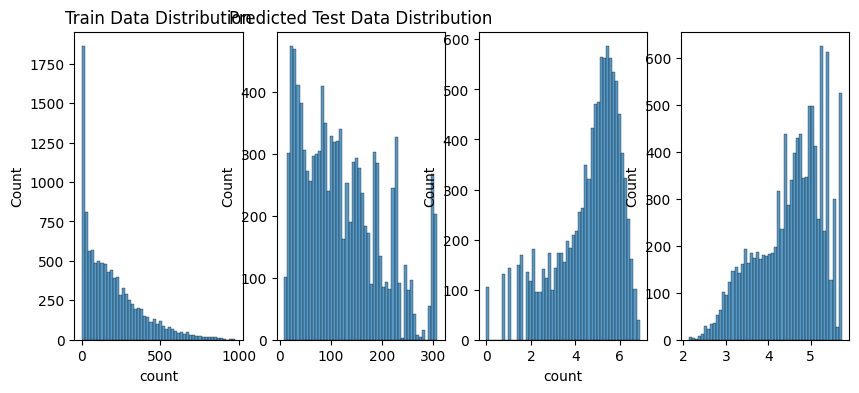

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

figure, axes = plt.subplots(ncols=4)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(beyes_best_pred), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution')
sns.histplot(np.log(y), bins=50, ax=axes[2])
axes[0].set_title('Train Data Distribution')
sns.histplot(beyes_best_pred, bins=50, ax=axes[3])
axes[1].set_title('Predicted Test Data Distribution')

In [199]:
submission['count'] = np.exp(test_pred)
submission.to_csv('submission.csv', index=False)
submission

,datetime,count
0,2011-01-20 00:00:00,11.678043
1,2011-01-20 01:00:00,5.635479
2,2011-01-20 02:00:00,3.136616
3,2011-01-20 03:00:00,1.810810
4,2011-01-20 04:00:00,1.763417
...,...,...
6488,2012-12-31 19:00:00,213.716385
6489,2012-12-31 20:00:00,149.915268
6490,2012-12-31 21:00:00,104.632835
6491,2012-12-31 22:00:00,78.582321
